
Looking here at alpha (10Hz) and beta (20Hz) oscillations during hand movement
-Expect these to be suppresed in the conralateral motor cortex so should see reduction in signal power in the that frequenzy band
-Called the Event Related Desynconrization
  -found during but also before visual stimulation
   Two different types of ERD can be differentiated: 
        one short-lasting, localized to occipital areas and involving upper alpha components; 
        the other longer lasting, more widespread, most prominent over parietal areas and maximal for lower alpha components. 
The former most likely reflects primary visual processing and feature extraction, the latter is more related to cognitive processing and mechanisms of attention.


Use MNE Python to epoch signals that are corresponding to hand movement.
Assume the hand movements occurs before the 'replacing an object' event

Use Common Spaital Patterns algorithm to extract spatial filters that max difference of variance during and after movement.
Then visualize the spectrum corresponding to that movement.

For each subject should see:
  - Spot over the electrode C3 (left motor cortex, correspondng to right hand movement)
  - Decrease of signal power in 10 and 20 Hz during the movement (referenced against after the movement)

Unfortunately each subject has:
- Different Cortex organization
- Different alpha/beta peek

ALSO CSP algrorithm sensitive to artefacts so we may get false maps e.g. subject  seemd to trigger on eye movements

In [1]:
import numpy as np
import pandas as pd

Epochs usually defined as time locked to the stimulus. For example epoch may begin 100 ms before onset of stimulus and end 1000 ms after. Within this epoch there may be voltage changes that are specifically related to the brain's response to the stimulus. These events constitute the 'event related potential.'

In [2]:
from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score, LeaveOneLabelOut
from glob import glob

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
%matplotlib inline

In [6]:
from scipy.signal import welch
from mne import pick_types

In [7]:
def read_csv_file(file_name):
    #Read in file with pandas method
    data = pd.read_csv(file_name)
    return data

In [8]:
def create_mne_raw_object(file_name):
    """Create raw mne instance from csv"""
    data = read_csv_file(file_name)
    events_file_name = file_name.replace('_data', '_events')
    events = pd.read_csv(events_file_name)

    #Get channel names (electrode channels)
    channel_names = list(data.columns[1:])
    
    #Get event names
    event_names = list(events.columns[1:])
    
    #Put data and events into numpy arrays
    events_data = np.array(events[event_names]).T
    
    #concat events file and data (events goes onto the end)
    data = np.concatenate((1e-6*np.array(data[channel_names]).T, events_data))
    #read EEG standard montage from mne
    montage = read_montage('standard_1005', channel_names)
    
    #Define channel type
    #First is EEG (32 channells)
    #Last 6 are stimulations
    channel_type = ['eeg']*len(channel_names) + ['stim']*6
#     print(channel_type, len(channel_type))
    
    #create and populate MNE info structure
    channel_names.extend(event_names)
    
#     print(channel_names)
    
    mne_info = create_info(channel_names, sfreq=500.0, ch_types=channel_type, montage=montage)
    mne_info['filename'] = file_name
#     print(mne_info)
    
    #create raw data, mne object (from numpy array)
    #data is the channels time series
    #mne_info is the mne information dictionary
    raw = RawArray(data, mne_info, verbose=False)
    return raw
    
    
    

In [9]:
raw_mne = create_mne_raw_object('./data/train/subj10_series1_data.csv')

<Epochs  |  n_events : 520 (all good), tmin : -2.0 (s), tmax : -0.5 (s), baseline : None,
 'after': 520, 'during': 520>


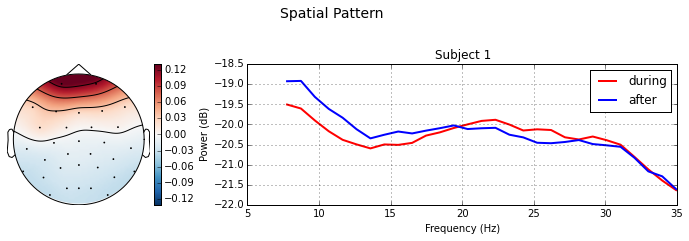

subject 1: AUC cross val score: 0.880
<Epochs  |  n_events : 520 (all good), tmin : -2.0 (s), tmax : -0.5 (s), baseline : None,
 'after': 520, 'during': 520>


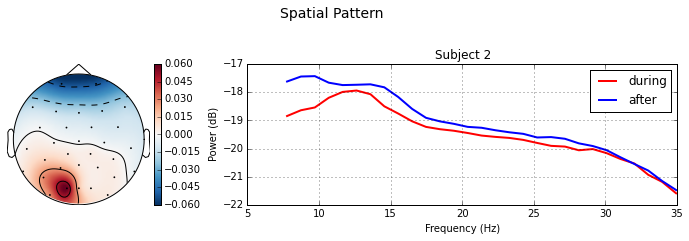

subject 2: AUC cross val score: 0.867
<Epochs  |  n_events : 520 (all good), tmin : -2.0 (s), tmax : -0.5 (s), baseline : None,
 'after': 520, 'during': 520>


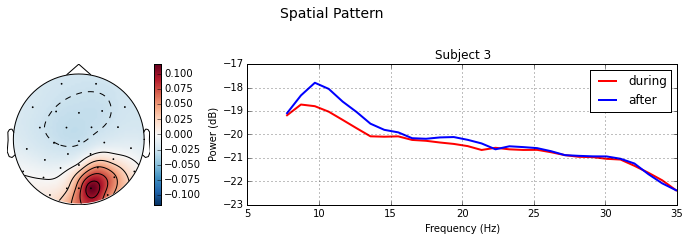

subject 3: AUC cross val score: 0.828
<Epochs  |  n_events : 520 (all good), tmin : -2.0 (s), tmax : -0.5 (s), baseline : None,
 'after': 520, 'during': 520>


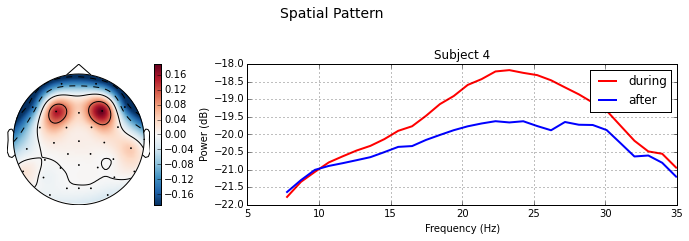

subject 4: AUC cross val score: 0.751
<Epochs  |  n_events : 520 (all good), tmin : -2.0 (s), tmax : -0.5 (s), baseline : None,
 'after': 520, 'during': 520>


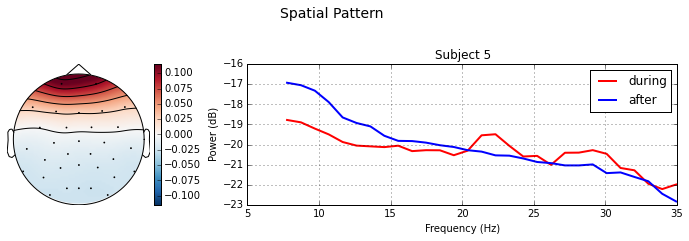

subject 5: AUC cross val score: 0.850


In [10]:
subjects = range(1,6)
#create list for analysing fit of model
auc = []

for subject in subjects:
    total_epochs = []
    
    #event id = 'HandStart' (assuming handstart occurs before 'replace' event)
    file_names = glob('./data/train/subj%d_series*_data.csv' % (subject))
    session = []
    y = []
    
    #iterate over file names
    for series_index, filename in enumerate(file_names):
        
        #read data
        raw = create_mne_raw_object(filename)
        
        #pick the channels by type and name
        picks = pick_types(raw.info, eeg=True)
        
        #Filter data for alpha frequency and beta band (alpha approx 8-12 Hz, beta approx 16-31 Hz)
        #Note MNE implements a zero phase (filtfilt) filtering that isn't compatible with the no future data rule
        #filfilt: forward-backward filtering, i.e., filter, reverse the signal, filter again and then reverse again
        #because we only carea about alpha and beta we cut off everything outside this band
        
        """
        Params
         lfreq: low-cut off freq
         hreq:  high-cut off freq
         picks: indices of channels to filter (our eeg reading channels)
         method: 'iir' is forward-backward filtering via filtfilt (not allowed in competition)
         njobs: number of jobs to run in paralell
        """
        raw.filter(7, 35, picks=picks, method='iir', n_jobs=-1, verbose=False)
        
        #We are just focused on the 'replace' event so get the position corresponding to that
        #looks it up in our Raw MNE, first 32 events are EEG readings, last 6 are stimuli
        events = find_events(raw, stim_channel='LiftOff', verbose = False)
        
        #epochs signal for 1.5 seconds before the movement
        #will make list of epochs from raw object
        #So we are just defining the epochs by their band around the trigger
        """
        raw: instance of raw MNE info
        events: events that we care about (here we are focused on replace event)
        event_id: id of the event to consider (i think during is how long it lasts which is weird because they should be 2ms)
        time_min: startime before the event (2 ms before here)
        time_max: endtime after the event(i think this is disallowed in the competition)
        proj: whether or not want to apply SSP projection vectors
        """
        epochs = Epochs(raw, events, {'during': 1}, -2, -0.5, proj=False,
                       picks=picks,
                       baseline=None,
                       preload=True,
                       add_eeg_ref=False,
                       verbose=False)
        
        total_epochs.append(epochs)
        session.extend([series_index]*len(epochs))
        y.extend([1]*len(epochs))
        
        #epochs signal for 1.5 seconds aftr the movement (corresponds to the rest period)
        epochs_rest_period = Epochs(raw, events, {'after': 1}, 0.5, 2, proj=False,
                                   picks=picks,
                                   baseline=None,
                                   preload=True,
                                   add_eeg_ref=False,
                                   verbose=False)
        
        #workaround so we can concatenate epochs
        epochs_rest_period.times = epochs.times
        
        total_epochs.append(epochs_rest_period)
        session.extend([series_index]*len(epochs_rest_period))
        y.extend([-1]*len(epochs_rest_period))
        
    #concat all epochs
    epochs = concatenate_epochs(total_epochs)
    print(epochs)
    
    #get the data
    X = epochs.get_data()
    Y = np.array(y)
    
    #Run CSP (Common Spatial Pattern Filter)
    #MNE EEG signal decomposition using the Common Spatial Patterns (CSP)
    #note the object can be used as supervised decomp. to estimate spatial filters
    # for feature extraction in a 2 class decoding problem
    
    """
    n_comp: The number of components to decompose M/EEG signals. This number should be set by cross-validation. (def=4)
    log: if True apply log to standardize features (we did some standardization earlier already)
         if False features z-scored
    reg: allow regularization for covariance estimation if float. Shrinkage covariance used.
         if reg=str optimal shrinkage using lws (Ledoit-Wolf Shrinkage)
    """

    csp = CSP(reg='lws')
    csp.fit(X,y)
    
    #compute spatial filtered spectrum
    po = []
    for x in X:
        f, p = welch(np.dot(csp.filters_[0,:].T,x), 500, nperseg=515) #Compute estimate power spectral density
                                                                      #strength of the variations(energy) 
                                                                      #as a function of frequency
        po.append(p)
    po = np.array(po)
    
    
    #prepare topoplot
    """
    evoked
    ch_type
    layout
    """
    _,epos,_,_,_ = _prepare_topo_plot(epochs, 'eeg', None) #scalp topography plot of our various bands
    
     # plot first pattern
    pattern = csp.patterns_[0,:]
    pattern -= pattern.mean()
    ix = np.argmax(abs(pattern))
    # the parttern is sign invariant.
    # invert it for display purpose
    if pattern[ix]>0:
        sign = 1.0
    else:
        sign = -1.0
    
    fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
    title = 'Spatial Pattern'
    fig.suptitle(title, fontsize=14)
    img, _ = plot_topomap(sign*pattern,epos,axis=ax_topo,show=False)
    divider = make_axes_locatable(ax_topo)
    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(img, cax=ax_colorbar)
    
    # plot spectrum
    fix = (f>7) & (f<35)
    ax_spectrum = divider.append_axes('right', size='300%', pad=1.2)
    ax_spectrum.plot(f[fix],np.log(po[Y==1][:,fix].mean(axis=0).T),'-r',lw=2)
    ax_spectrum.plot(f[fix],np.log(po[Y==-1][:,fix].mean(axis=0).T),'-b',lw=2)
    ax_spectrum.set_xlabel('Frequency (Hz)')
    ax_spectrum.set_ylabel('Power (dB)')
    plt.grid()
    plt.legend(['during','after'])
    plt.title('Subject %d' % subject)
    plt.show()
    plt.savefig('./Images/spatial_pattern_subject_%02d.png' % subject ,bbox_inches='tight')
        
        
    #Run Cross Validation
    clf = make_pipeline(CSP(), LogisticRegression())
    cv = LeaveOneLabelOut(session)
    auc.append(cross_val_score(clf, X, Y, cv=cv, scoring='roc_auc').mean())
    print('subject %d: AUC cross val score: %.3f' %(subject, auc[-1]))

        
        

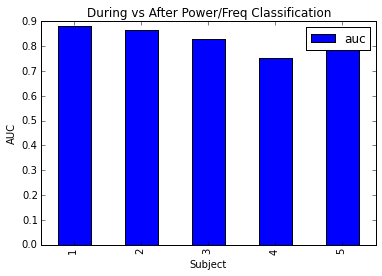

In [11]:
auc = pd.DataFrame(data=auc, index=subjects, columns=['auc'])
auc.to_csv('cross_val_auc.csv')
plt.figure(figsize=(4,4))
auc.plot(kind='bar', y='auc')
plt.xlabel('Subject')
plt.ylabel('AUC')
plt.title('During vs After Power/Freq Classification')
plt.savefig('./Images/cross_val_score_auc.png', bbox_inches='tight')